In [ ]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pre_data as eda
import matplotlib.pyplot as plt

# 데이터 로드 및 전처리
data = pd.read_csv('./data/train.csv', encoding='cp949')
preprocessed_data = eda.preprocessing(data)

# 1. 데이터 전처리 (범주형 데이터 변환 및 스케일링)
object_columns = preprocessed_data.select_dtypes(include=['object'])
convert_data, _ = eda.convert_category_into_integer(preprocessed_data, object_columns)

# 타겟 변수 및 독립 변수 설정
X = convert_data.drop('Churn', axis=1)
y = convert_data['Churn'].astype(int)

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# X: 피처 데이터셋, y: 타겟(종속 변수) 데이터셋
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 인덱스 재설정 (reset_index)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# 클래스 불균형 해결 (scale_pos_weight 사용)
class_counts = y_train.value_counts()
scale_pos_weight = class_counts[0] / class_counts[1]  # 클래스 비율

# 하이퍼 파라미터 설정 (GPU 사용 추가)
params = {
    'n_estimators': 200,
    'max_depth': 5,
    'learning_rate': 0.01,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'scale_pos_weight': scale_pos_weight,  # 클래스 불균형 해소를 위한 파라미터
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'tree_method': 'gpu_hist',  # CUDA 사용을 위한 GPU 설정
    'predictor': 'gpu_predictor'  # GPU로 예측 수행
}

# XGBoost 모델을 사용한 전진 선택법
def forward_selection_xgboost(X_train, X_test, y_train, y_test):
    model = XGBClassifier(**params)  # 설정된 하이퍼 파라미터로 XGBoost 모델 선언 (CUDA 사용)

    selected_features = []  # 선택된 피처를 저장할 리스트
    remaining_features = list(X_train.columns)  # 남은 피처 리스트

    # 성능 지표를 저장할 리스트
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    while remaining_features:
        best_feature = None
        best_score = 0

        # 각 남은 피처를 하나씩 추가해가며 성능 평가
        for feature in remaining_features:
            current_features = selected_features + [feature]
            X_train_subset = X_train[current_features]
            X_test_subset = X_test[current_features]

            # 모델 학습
            model.fit(X_train_subset, y_train)

            # 모델 평가
            y_pred_class = model.predict(X_test_subset)

            accuracy = accuracy_score(y_test, y_pred_class)
            precision = precision_score(y_test, y_pred_class)
            recall = recall_score(y_test, y_pred_class)
            f1 = f1_score(y_test, y_pred_class)

            # 가장 성능이 좋은 피처 선택
            if f1 > best_score:  # F1 스코어를 기준으로 성능 평가
                best_score = f1
                best_feature = feature

        # 선택된 피처와 성능 저장
        if best_feature is not None:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)

            # 성능 지표를 리스트에 저장
            accuracy_list.append(accuracy)
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)

            print(f"Selected '{best_feature}' with F1 Score: {best_score}")

    # 지표 그래프 시각화
    plot_metrics(accuracy_list, precision_list, recall_list, f1_list)

    return selected_features, model

# 성능 지표 그래프 그리기
def plot_metrics(accuracy, precision, recall, f1):
    epochs = range(1, len(accuracy) + 1)

    plt.figure(figsize=(10, 6))

    plt.plot(epochs, accuracy, label="Accuracy")
    plt.plot(epochs, precision, label="Precision")
    plt.plot(epochs, recall, label="Recall")
    plt.plot(epochs, f1, label="F1 Score")

    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title("Model Performance during Forward Selection")
    plt.legend()

    plt.grid(True)
    plt.show()

# 전진 선택법 실행
selected_features, final_model = forward_selection_xgboost(X_train, X_test, y_train, y_test)

# 최종 선택된 피처들로 최종 모델 학습 및 평가
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

final_model.fit(X_train_selected, y_train)
y_pred_class = final_model.predict(X_test_selected)

# 최종 성능 평가
accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)

# 최종 성능 출력
print("\nFinal Model Performance:")
print(f"Final Model Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

In [7]:
# SMOTE로 클래스 불균형 해결
from imblearn.over_sampling import SMOTE

# 사용할 컬럼만 지정
selected_columns = ['ReferralsMadeBySubscriber', 'NonUSTravel', 'AdjustmentsToCreditRating', 
                    'OwnsMotorcycle', 'OptOutMailings', 'CallForwardingCalls', 'RetentionCalls','Churn']

# 데이터 로드 및 전처리
data = pd.read_csv('./data/train.csv', encoding='cp949')
preprocessed_data = eda.preprocessing(data)  # 기본 전처리 수행
object_columns = preprocessed_data.select_dtypes(include=['object'])
convert_data, _ = eda.convert_category_into_integer(preprocessed_data, object_columns)
# 1. 필요한 컬럼만 사용
X = convert_data[selected_columns].drop(columns='Churn')
y = convert_data['Churn'].astype(int)

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# XGBoost 모델 학습
xgb = XGBClassifier(
    n_estimators=200, max_depth=5, learning_rate=0.01,
    colsample_bytree=0.8, subsample=0.8, scale_pos_weight=scale_pos_weight,
    eval_metric='logloss', use_label_encoder=False
)

xgb.fit(X_resampled, y_resampled)
y_pred = xgb.predict(X_test)

# 최종 성능 평가
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


nan-value filled
MonthlyRevenue : 50887, 삭제된 수 : 1
MonthlyMinutes : 50883, 삭제된 수 : 4
TotalRecurringCharge : 50874, 삭제된 수 : 9
DirectorAssistedCalls : 50874, 삭제된 수 : 0
OverageMinutes : 50870, 삭제된 수 : 4
RoamingCalls : 50862, 삭제된 수 : 8
PercChangeMinutes : 50860, 삭제된 수 : 2
DroppedCalls : 50856, 삭제된 수 : 4
BlockedCalls : 50852, 삭제된 수 : 4
UnansweredCalls : 50842, 삭제된 수 : 10
CustomerCareCalls : 50840, 삭제된 수 : 2
ThreewayCalls : 50836, 삭제된 수 : 4
ReceivedCalls : 50830, 삭제된 수 : 6
OutboundCalls : 50827, 삭제된 수 : 3
InboundCalls : 50823, 삭제된 수 : 4
PeakCallsInOut : 50821, 삭제된 수 : 2
OffPeakCallsInOut : 50806, 삭제된 수 : 15
DroppedBlockedCalls : 50792, 삭제된 수 : 14
CallForwardingCalls : 50779, 삭제된 수 : 13
CallWaitingCalls : 50779, 삭제된 수 : 0
MonthsInService : 50778, 삭제된 수 : 1
UniqueSubs : 50777, 삭제된 수 : 1
ActiveSubs : 50777, 삭제된 수 : 0
Handsets : 50773, 삭제된 수 : 4
HandsetModels : 50773, 삭제된 수 : 0
CurrentEquipmentDays : 50768, 삭제된 수 : 5
RetentionCalls : 50634, 삭제된 수 : 134
RetentionOffersAccepted : 50634, 삭제된 수 : 0


c:\Utils\anaconda3\envs\deep_learning\lib\site-packages\xgboost\core.py:158: UserWarning: [21:46:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.2877037037037037
Precision: 0.2871404566571118
Recall: 1.0
F1 Score: 0.4461680233451083


nan-value filled
MonthlyRevenue : 50887, 삭제된 수 : 1
MonthlyMinutes : 50883, 삭제된 수 : 4
TotalRecurringCharge : 50874, 삭제된 수 : 9
DirectorAssistedCalls : 50874, 삭제된 수 : 0
OverageMinutes : 50870, 삭제된 수 : 4
RoamingCalls : 50862, 삭제된 수 : 8
PercChangeMinutes : 50860, 삭제된 수 : 2
DroppedCalls : 50856, 삭제된 수 : 4
BlockedCalls : 50852, 삭제된 수 : 4
UnansweredCalls : 50842, 삭제된 수 : 10
CustomerCareCalls : 50840, 삭제된 수 : 2
ThreewayCalls : 50836, 삭제된 수 : 4
ReceivedCalls : 50830, 삭제된 수 : 6
OutboundCalls : 50827, 삭제된 수 : 3
InboundCalls : 50823, 삭제된 수 : 4
PeakCallsInOut : 50821, 삭제된 수 : 2
OffPeakCallsInOut : 50806, 삭제된 수 : 15
DroppedBlockedCalls : 50792, 삭제된 수 : 14
CallForwardingCalls : 50779, 삭제된 수 : 13
CallWaitingCalls : 50779, 삭제된 수 : 0
MonthsInService : 50778, 삭제된 수 : 1
UniqueSubs : 50777, 삭제된 수 : 1
ActiveSubs : 50777, 삭제된 수 : 0
Handsets : 50773, 삭제된 수 : 4
HandsetModels : 50773, 삭제된 수 : 0
CurrentEquipmentDays : 50768, 삭제된 수 : 5
RetentionCalls : 50634, 삭제된 수 : 134
RetentionOffersAccepted : 50634, 삭제된 수 : 0


c:\Utils\anaconda3\envs\deep_learning\lib\site-packages\xgboost\core.py:158: UserWarning: [10:27:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Utils\anaconda3\envs\deep_learning\lib\site-packages\xgboost\core.py:158: UserWarning: [10:27:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}

Final Model Performance on Train Data:
Train Accuracy: 0.5328180561043065
Train Precision: 0.35434016655989753
Train Recall: 0.760113372842051
Train F1 Score: 0.4833556350528414

Final Model Performance on Test Data:
Test Accuracy: 0.5303703703703704
Test Precision: 0.35172413793103446
Test Recall: 0.7546455609084652
Test F1 Score: 0.47981621266819824


c:\Utils\anaconda3\envs\deep_learning\lib\site-packages\xgboost\core.py:158: UserWarning: [10:27:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


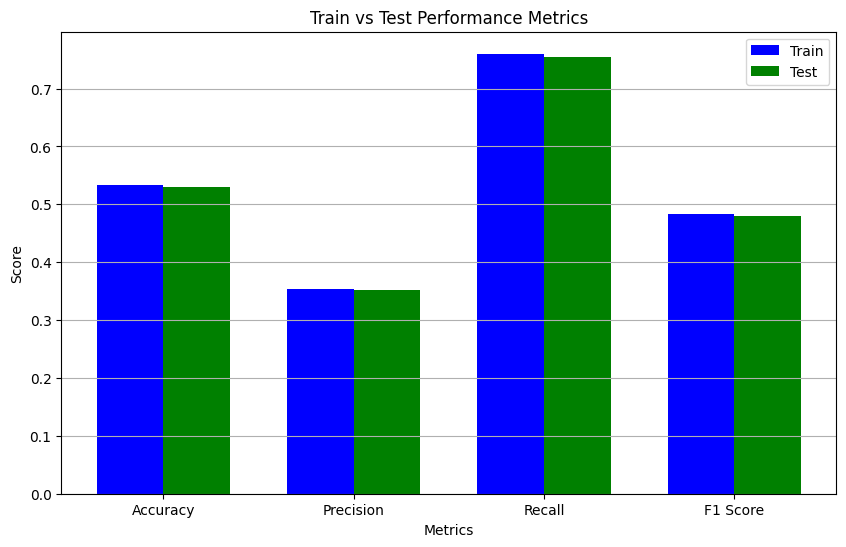

In [5]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pre_data as eda
import matplotlib.pyplot as plt

# 데이터 로드 및 전처리
data = pd.read_csv('./data/train.csv', encoding='cp949')
preprocessed_data = eda.preprocessing(data)

# 1. 데이터 전처리 (범주형 데이터 변환 및 스케일링)
object_columns = preprocessed_data.select_dtypes(include=['object'])
convert_data, _ = eda.convert_category_into_integer(preprocessed_data, object_columns)

# 타겟 변수 및 독립 변수 설정 (4개의 피처만 선택)
X = convert_data[['CurrentEquipmentDays', 'MonthsInService', 'HandsetRefurbished', 'AdjustmentsToCreditRating']]
y = convert_data['Churn'].astype(int)

# 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

# 클래스 불균형 해결 (scale_pos_weight 사용)
class_counts = y_train.value_counts()
scale_pos_weight = class_counts[0] / class_counts[1]  # 클래스 비율

# 하이퍼파라미터 설정
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight, tree_method='gpu_hist', predictor='gpu_predictor')

# 하이퍼파라미터 그리드 설정 (튜닝할 파라미터)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

# GridSearchCV로 하이퍼파라미터 튜닝 (5-fold 교차 검증)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=3)

# 모델 학습
grid_search.fit(X_train_scaled, y_train)

# 최적의 하이퍼파라미터 출력
print("Best Hyperparameters:", grid_search.best_params_)

# 최종 모델 평가 (교차 검증 결과)
best_model = grid_search.best_estimator_

# 성능 기록을 위한 리스트
accuracy_train_list, precision_train_list, recall_train_list, f1_train_list = [], [], [], []
accuracy_test_list, precision_test_list, recall_test_list, f1_test_list = [], [], [], []

# 훈련 데이터에서 성능 평가
y_pred_train = best_model.predict(X_train_scaled)
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train)
recall_train = recall_score(y_train, y_pred_train)
f1_train = f1_score(y_train, y_pred_train)

accuracy_train_list.append(accuracy_train)
precision_train_list.append(precision_train)
recall_train_list.append(recall_train)
f1_train_list.append(f1_train)

# 테스트 데이터에서 성능 평가
y_pred_class = best_model.predict(X_test_scaled)
accuracy_test = accuracy_score(y_test, y_pred_class)
precision_test = precision_score(y_test, y_pred_class)
recall_test = recall_score(y_test, y_pred_class)
f1_test = f1_score(y_test, y_pred_class)

accuracy_test_list.append(accuracy_test)
precision_test_list.append(precision_test)
recall_test_list.append(recall_test)
f1_test_list.append(f1_test)

# 성능 기록 출력
print("\nFinal Model Performance on Train Data:")
print(f"Train Accuracy: {accuracy_train}")
print(f"Train Precision: {precision_train}")
print(f"Train Recall: {recall_train}")
print(f"Train F1 Score: {f1_train}")

print("\nFinal Model Performance on Test Data:")
print(f"Test Accuracy: {accuracy_test}")
print(f"Test Precision: {precision_test}")
print(f"Test Recall: {recall_test}")
print(f"Test F1 Score: {f1_test}")

def plot_metrics(acc_train, prec_train, rec_train, f1_train, acc_test, prec_test, rec_test, f1_test):
    # 막대 그래프에서 각 성능 지표를 표현하기 위해 리스트로 묶음
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    
    # 훈련 데이터와 테스트 데이터의 성능 지표
    train_scores = [acc_train[0], prec_train[0], rec_train[0], f1_train[0]]
    test_scores = [acc_test[0], prec_test[0], rec_test[0], f1_test[0]]

    # 막대 그래프 그리기
    x = np.arange(len(metrics))  # 성능 지표의 위치
    width = 0.35  # 막대의 폭

    plt.figure(figsize=(10, 6))

    # 훈련 데이터 성능
    plt.bar(x - width/2, train_scores, width, label='Train', color='blue')

    # 테스트 데이터 성능
    plt.bar(x + width/2, test_scores, width, label='Test', color='green')

    # 그래프 설정
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Train vs Test Performance Metrics')

    # x축에 성능 지표 이름 설정
    plt.xticks(x, metrics)

    plt.legend()
    plt.grid(True, axis='y')  # y축에만 그리드 표시
    plt.show()

# 성능 그래프 그리기 (막대 그래프)
plot_metrics(accuracy_train_list, precision_train_list, recall_train_list, f1_train_list,
             accuracy_test_list, precision_test_list, recall_test_list, f1_test_list)



nan-value filled
MonthlyRevenue : 50887, 삭제된 수 : 1
MonthlyMinutes : 50883, 삭제된 수 : 4
TotalRecurringCharge : 50874, 삭제된 수 : 9
DirectorAssistedCalls : 50874, 삭제된 수 : 0
OverageMinutes : 50870, 삭제된 수 : 4
RoamingCalls : 50862, 삭제된 수 : 8
PercChangeMinutes : 50860, 삭제된 수 : 2
DroppedCalls : 50856, 삭제된 수 : 4
BlockedCalls : 50852, 삭제된 수 : 4
UnansweredCalls : 50842, 삭제된 수 : 10
CustomerCareCalls : 50840, 삭제된 수 : 2
ThreewayCalls : 50836, 삭제된 수 : 4
ReceivedCalls : 50830, 삭제된 수 : 6
OutboundCalls : 50827, 삭제된 수 : 3
InboundCalls : 50823, 삭제된 수 : 4
PeakCallsInOut : 50821, 삭제된 수 : 2
OffPeakCallsInOut : 50806, 삭제된 수 : 15
DroppedBlockedCalls : 50792, 삭제된 수 : 14
CallForwardingCalls : 50779, 삭제된 수 : 13
CallWaitingCalls : 50779, 삭제된 수 : 0
MonthsInService : 50778, 삭제된 수 : 1
UniqueSubs : 50777, 삭제된 수 : 1
ActiveSubs : 50777, 삭제된 수 : 0
Handsets : 50773, 삭제된 수 : 4
HandsetModels : 50773, 삭제된 수 : 0
CurrentEquipmentDays : 50768, 삭제된 수 : 5
RetentionCalls : 50634, 삭제된 수 : 134
RetentionOffersAccepted : 50634, 삭제된 수 : 0


c:\Utils\anaconda3\envs\deep_learning\lib\site-packages\xgboost\core.py:158: UserWarning: [10:33:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Utils\anaconda3\envs\deep_learning\lib\site-packages\xgboost\core.py:158: UserWarning: [10:33:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Utils\anaconda3\envs\deep_learning\lib\site-packages\xgboost\core.py:158: UserWarning: [10:33:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\x

Best Hyperparameters: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 1.0}

Final Model Performance on Train Data:
Train Accuracy: 0.5543016594231529
Train Precision: 0.3529114621601763
Train Recall: 0.6600532508803573
Train F1 Score: 0.45991801071246896

Final Model Performance on Test Data:
Test Accuracy: 0.5555555555555556
Test Precision: 0.35338484179543783
Test Recall: 0.6610461114934618
Test F1 Score: 0.46056101654279546


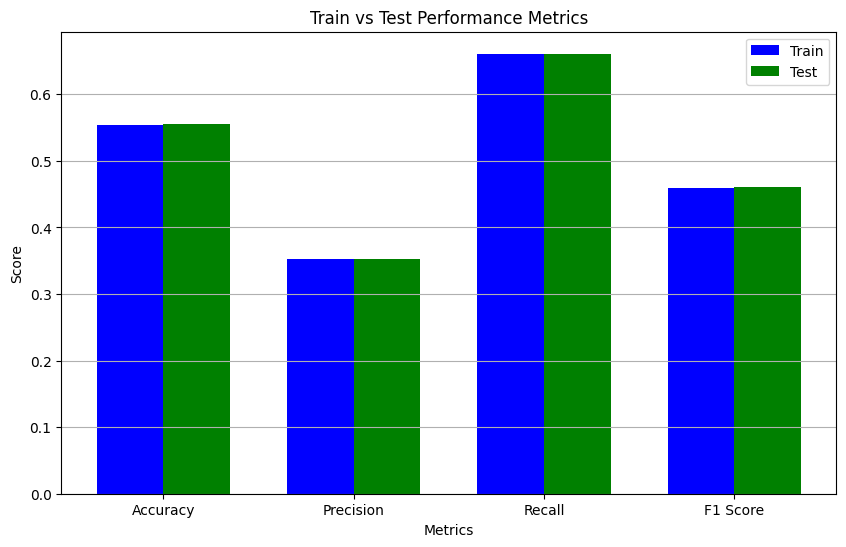

In [6]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import numpy as np
import pre_data as eda
import matplotlib.pyplot as plt

# 데이터 로드 및 전처리
data = pd.read_csv('./data/train.csv', encoding='cp949')
preprocessed_data = eda.preprocessing(data)

# 1. 데이터 전처리 (범주형 데이터 변환 및 스케일링)
object_columns = preprocessed_data.select_dtypes(include=['object'])
convert_data, _ = eda.convert_category_into_integer(preprocessed_data, object_columns)

# 타겟 변수 및 독립 변수 설정 (4개의 피처만 선택)
X = convert_data[['CurrentEquipmentDays', 'MonthsInService', 'HandsetRefurbished', 'AdjustmentsToCreditRating']]
y = convert_data['Churn'].astype(int)

# 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 클래스 불균형 해결을 위한 SMOTE를 파이프라인에 포함
# 파이프라인에서 먼저 SMOTE를 적용한 후 스케일링, 그 후 XGBoost를 학습
pipeline = Pipeline([
    ('smote', SMOTE(random_state=0)),  # SMOTE 적용
    ('scaler', StandardScaler()),  # 스케일링 적용
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', tree_method='gpu_hist', predictor='gpu_predictor'))
])

# 하이퍼파라미터 그리드 설정 (튜닝할 파라미터)
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
}

# GridSearchCV로 하이퍼파라미터 튜닝 (5-fold 교차 검증)
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=3)

# 모델 학습
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best Hyperparameters:", grid_search.best_params_)

# 최종 모델 평가 (교차 검증 결과)
best_model = grid_search.best_estimator_

# 성능 기록을 위한 리스트
accuracy_train_list, precision_train_list, recall_train_list, f1_train_list = [], [], [], []
accuracy_test_list, precision_test_list, recall_test_list, f1_test_list = [], [], [], []

# 훈련 데이터에서 성능 평가
y_pred_train = best_model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train)
recall_train = recall_score(y_train, y_pred_train)
f1_train = f1_score(y_train, y_pred_train)

accuracy_train_list.append(accuracy_train)
precision_train_list.append(precision_train)
recall_train_list.append(recall_train)
f1_train_list.append(f1_train)

# 테스트 데이터에서 성능 평가
y_pred_class = best_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_class)
precision_test = precision_score(y_test, y_pred_class)
recall_test = recall_score(y_test, y_pred_class)
f1_test = f1_score(y_test, y_pred_class)

accuracy_test_list.append(accuracy_test)
precision_test_list.append(precision_test)
recall_test_list.append(recall_test)
f1_test_list.append(f1_test)

# 성능 기록 출력
print("\nFinal Model Performance on Train Data:")
print(f"Train Accuracy: {accuracy_train}")
print(f"Train Precision: {precision_train}")
print(f"Train Recall: {recall_train}")
print(f"Train F1 Score: {f1_train}")

print("\nFinal Model Performance on Test Data:")
print(f"Test Accuracy: {accuracy_test}")
print(f"Test Precision: {precision_test}")
print(f"Test Recall: {recall_test}")
print(f"Test F1 Score: {f1_test}")

# 성능 지표 그래프 그리기 (막대 그래프)
def plot_metrics(acc_train, prec_train, rec_train, f1_train, acc_test, prec_test, rec_test, f1_test):
    # 막대 그래프에서 각 성능 지표를 표현하기 위해 리스트로 묶음
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    
    # 훈련 데이터와 테스트 데이터의 성능 지표
    train_scores = [acc_train[0], prec_train[0], rec_train[0], f1_train[0]]
    test_scores = [acc_test[0], prec_test[0], rec_test[0], f1_test[0]]

    # 막대 그래프 그리기
    x = np.arange(len(metrics))  # 성능 지표의 위치
    width = 0.35  # 막대의 폭

    plt.figure(figsize=(10, 6))

    # 훈련 데이터 성능
    plt.bar(x - width/2, train_scores, width, label='Train', color='blue')

    # 테스트 데이터 성능
    plt.bar(x + width/2, test_scores, width, label='Test', color='green')

    # 그래프 설정
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Train vs Test Performance Metrics')

    # x축에 성능 지표 이름 설정
    plt.xticks(x, metrics)

    plt.legend()
    plt.grid(True, axis='y')  # y축에만 그리드 표시
    plt.show()

# 성능 그래프 그리기
plot_metrics(accuracy_train_list, precision_train_list, recall_train_list, f1_train_list,
             accuracy_test_list, precision_test_list, recall_test_list, f1_test_list)


nan-value filled
MonthlyRevenue : 50887, 삭제된 수 : 1
MonthlyMinutes : 50883, 삭제된 수 : 4
TotalRecurringCharge : 50874, 삭제된 수 : 9
DirectorAssistedCalls : 50874, 삭제된 수 : 0
OverageMinutes : 50870, 삭제된 수 : 4
RoamingCalls : 50862, 삭제된 수 : 8
PercChangeMinutes : 50860, 삭제된 수 : 2
DroppedCalls : 50856, 삭제된 수 : 4
BlockedCalls : 50852, 삭제된 수 : 4
UnansweredCalls : 50842, 삭제된 수 : 10
CustomerCareCalls : 50840, 삭제된 수 : 2
ThreewayCalls : 50836, 삭제된 수 : 4
ReceivedCalls : 50830, 삭제된 수 : 6
OutboundCalls : 50827, 삭제된 수 : 3
InboundCalls : 50823, 삭제된 수 : 4
PeakCallsInOut : 50821, 삭제된 수 : 2
OffPeakCallsInOut : 50806, 삭제된 수 : 15
DroppedBlockedCalls : 50792, 삭제된 수 : 14
CallForwardingCalls : 50779, 삭제된 수 : 13
CallWaitingCalls : 50779, 삭제된 수 : 0
MonthsInService : 50778, 삭제된 수 : 1
UniqueSubs : 50777, 삭제된 수 : 1
ActiveSubs : 50777, 삭제된 수 : 0
Handsets : 50773, 삭제된 수 : 4
HandsetModels : 50773, 삭제된 수 : 0
CurrentEquipmentDays : 50768, 삭제된 수 : 5
RetentionCalls : 50634, 삭제된 수 : 134
RetentionOffersAccepted : 50634, 삭제된 수 : 0


c:\Utils\anaconda3\envs\deep_learning\lib\site-packages\xgboost\core.py:158: UserWarning: [11:55:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Utils\anaconda3\envs\deep_learning\lib\site-packages\xgboost\core.py:158: UserWarning: [11:55:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "classifier__colsample_bytree", "classifier__gamma", "classifier__learning_rate", "classifier__max_depth", "classifier__min_child_weight", "classifier__n_estimators", "classifier__reg_alpha", "classifier__reg_lambda", "classifier__subsample", "predictor", "use_label_encoder" } are no

Best Hyperparameters: {'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 100, 'classifier__reg_alpha': 0, 'classifier__reg_lambda': 1, 'classifier__subsample': 0.8}

Final Model Performance on Train Data:
Train Accuracy: 0.5883790991702884
Train Precision: 0.3889821523237321
Train Recall: 0.7562483895903118
Train F1 Score: 0.513725604597567

Final Model Performance on Test Data:
Test Accuracy: 0.5483456790123457
Test Precision: 0.35129348795718107
Test Recall: 0.6775636613902272
Test F1 Score: 0.4626953354482434


c:\Utils\anaconda3\envs\deep_learning\lib\site-packages\xgboost\core.py:158: UserWarning: [11:55:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


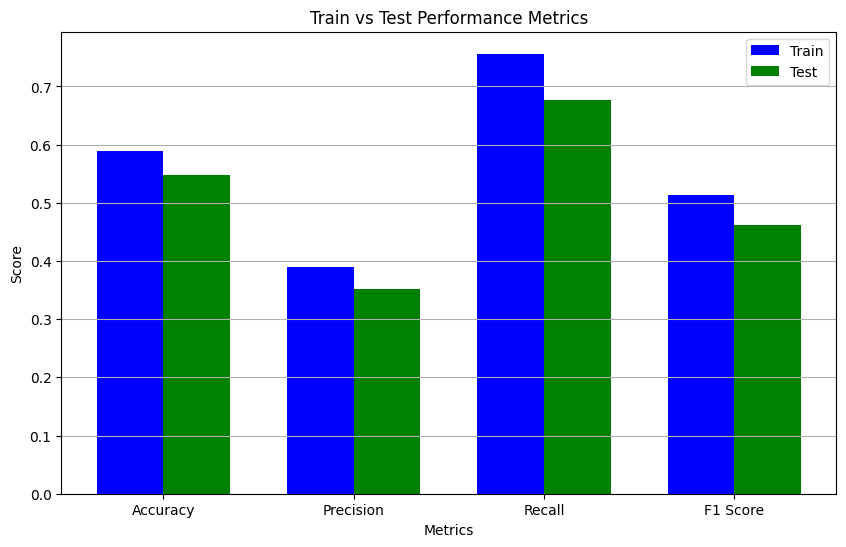

In [7]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pre_data as eda
import matplotlib.pyplot as plt

# 데이터 로드 및 전처리
data = pd.read_csv('./data/train.csv', encoding='cp949')
preprocessed_data = eda.preprocessing(data)

# 1. 데이터 전처리 (범주형 데이터 변환 및 스케일링)
object_columns = preprocessed_data.select_dtypes(include=['object'])
convert_data, _ = eda.convert_category_into_integer(preprocessed_data, object_columns)

# 타겟 변수 및 독립 변수 설정 (4개의 피처만 선택)
X = convert_data[['CurrentEquipmentDays', 'MonthsInService', 'HandsetRefurbished', 'AdjustmentsToCreditRating']]
y = convert_data['Churn'].astype(int)

# 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

# 클래스 불균형 해결 (scale_pos_weight 사용)
class_counts = y_train.value_counts()
scale_pos_weight = class_counts[0] / class_counts[1]  # 클래스 비율

# 하이퍼파라미터 설정
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight, tree_method='gpu_hist', predictor='gpu_predictor')

# 하이퍼파라미터 그리드 설정 (튜닝할 파라미터)
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
    'classifier__min_child_weight': [1, 3, 5],
    'classifier__gamma': [0, 0.1, 0.5],
    'classifier__reg_lambda': [1, 10, 100],  # L2 정규화
    'classifier__reg_alpha': [0, 0.1, 1]     # L1 정규화
}


# GridSearchCV로 하이퍼파라미터 튜닝 (5-fold 교차 검증)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=3)

# 모델 학습
grid_search.fit(X_train_scaled, y_train)

# 최적의 하이퍼파라미터 출력
print("Best Hyperparameters:", grid_search.best_params_)

# 최종 모델 평가 (교차 검증 결과)
best_model = grid_search.best_estimator_

# 성능 기록을 위한 리스트
accuracy_train_list, precision_train_list, recall_train_list, f1_train_list = [], [], [], []
accuracy_test_list, precision_test_list, recall_test_list, f1_test_list = [], [], [], []

# 훈련 데이터에서 성능 평가
y_pred_train = best_model.predict(X_train_scaled)
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train)
recall_train = recall_score(y_train, y_pred_train)
f1_train = f1_score(y_train, y_pred_train)

accuracy_train_list.append(accuracy_train)
precision_train_list.append(precision_train)
recall_train_list.append(recall_train)
f1_train_list.append(f1_train)

# 테스트 데이터에서 성능 평가
y_pred_class = best_model.predict(X_test_scaled)
accuracy_test = accuracy_score(y_test, y_pred_class)
precision_test = precision_score(y_test, y_pred_class)
recall_test = recall_score(y_test, y_pred_class)
f1_test = f1_score(y_test, y_pred_class)

accuracy_test_list.append(accuracy_test)
precision_test_list.append(precision_test)
recall_test_list.append(recall_test)
f1_test_list.append(f1_test)

# 성능 기록 출력
print("\nFinal Model Performance on Train Data:")
print(f"Train Accuracy: {accuracy_train}")
print(f"Train Precision: {precision_train}")
print(f"Train Recall: {recall_train}")
print(f"Train F1 Score: {f1_train}")

print("\nFinal Model Performance on Test Data:")
print(f"Test Accuracy: {accuracy_test}")
print(f"Test Precision: {precision_test}")
print(f"Test Recall: {recall_test}")
print(f"Test F1 Score: {f1_test}")

def plot_metrics(acc_train, prec_train, rec_train, f1_train, acc_test, prec_test, rec_test, f1_test):
    # 막대 그래프에서 각 성능 지표를 표현하기 위해 리스트로 묶음
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    
    # 훈련 데이터와 테스트 데이터의 성능 지표
    train_scores = [acc_train[0], prec_train[0], rec_train[0], f1_train[0]]
    test_scores = [acc_test[0], prec_test[0], rec_test[0], f1_test[0]]

    # 막대 그래프 그리기
    x = np.arange(len(metrics))  # 성능 지표의 위치
    width = 0.35  # 막대의 폭

    plt.figure(figsize=(10, 6))

    # 훈련 데이터 성능
    plt.bar(x - width/2, train_scores, width, label='Train', color='blue')

    # 테스트 데이터 성능
    plt.bar(x + width/2, test_scores, width, label='Test', color='green')

    # 그래프 설정
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Train vs Test Performance Metrics')

    # x축에 성능 지표 이름 설정
    plt.xticks(x, metrics)

    plt.legend()
    plt.grid(True, axis='y')  # y축에만 그리드 표시
    plt.show()

# 성능 그래프 그리기 (막대 그래프)
plot_metrics(accuracy_train_list, precision_train_list, recall_train_list, f1_train_list,
             accuracy_test_list, precision_test_list, recall_test_list, f1_test_list)

